In [2]:
import os

Below code to train CNN classification model

In [6]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers,optimizers
from keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.layers import Conv2D, MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import pickle              # For saving models to disk and loading saved models
import os
import zipfile
import PIL 
from PIL import Image, ImageDraw, ImageEnhance
import pathlib
import cv2 as cv2
import imgaug as ia
ia.seed(1)
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
import imageio
import re
import shutil

C:\Users\uprak\anaconda3\envs\tflow\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\uprak\anaconda3\envs\tflow\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\uprak\anaconda3\envs\tflow\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [7]:
# Initializing the random number generator
import random
random.seed(0)

# Ignoring the warnings
import warnings
warnings.filterwarnings("ignore")


In [8]:
os.getcwd()

'C:\\Users\\uprak\\capstone'

In [9]:
#path = os.getcwd()
path = 'C:\\yolo_result'
os.chdir(path)

In [10]:
ls

 Volume in drive C is Windows
 Volume Serial Number is D87D-3DAA

 Directory of C:\yolo_result

19-01-2022  00:16    <DIR>          .
19-01-2022  00:16    <DIR>          ..
18-01-2022  23:58           307,619 yolo_car_classification12_events.out.tfevents.1642401324.tf-gpu-1.22030.0
18-01-2022  23:58               372 yolo_car_classification12_hyp.yaml
19-01-2022  00:06           258,111 yolo_car_classification12_labels (1).jpg
19-01-2022  00:05           258,111 yolo_car_classification12_labels.jpg
19-01-2022  00:06           230,888 yolo_car_classification12_labels_correlogram.jpg
18-01-2022  23:59               709 yolo_car_classification12_opt.yaml
18-01-2022  23:59            36,456 yolo_car_classification12_results.csv
19-01-2022  00:05           180,294 yolo_car_classification12_train_batch0.jpg
19-01-2022  00:05           177,023 yolo_car_classification12_train_batch1.jpg
19-01-2022  00:05           172,418 yolo_car_classification12_train_batch2.jpg
              10 File(s)     

In [12]:
%cd ..

C:\


In [11]:
path

'C:\\Users\\uprak\\capstone'

In [12]:
car_img_path = os.path.join(path,'Car Images')
car_ann_path = os.path.join(path,'Annotations')
train_img_dir = os.path.join(car_img_path,'Train Images')
test_img_dir =  os.path.join(car_img_path,'Test Images')

In [13]:
def load_images_from_folder(folder):
    file_path = {}
    count = 0
    for folders in os.listdir(folder):
        #print(folders)
        if folders == '.DS_Store':
            pass
        else:
            foldername = os.path.join(folder,folders)
            #print(foldername)
            for filename in os.listdir(foldername):
                count = count+1
                filepath = os.path.join(foldername,filename)
                #file_name.append(filename)
                file_path[filename]=filepath
                #print(filename)
    return file_path

In [14]:
#Following function to plot the epochs vs loss and epoch vs metrics graph for training and validation results
def plot_curves(history,metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize = (10,5))
    for idx,key in enumerate(metrics):
        ax = fig.add_subplot(nrows,ncols,idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train','validation'],loc='upper left')

In [15]:
def resize_image(image_list,resize_path,image_size=224):
    for img in image_list:
        #print(img)
        im = cv2.imread(img,cv2.COLOR_BGR2RGB)
        old_size = im.shape[:2]  # old_size is in (height, width) format
        ratio = float(image_size) / max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        # new_size should be in (width, height) format
        im = cv2.resize(im, (new_size[1], new_size[0]))
        delta_w = image_size - new_size[1]
        delta_h = image_size - new_size[0]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        color = [0, 0, 0]
        new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                    value=color)
        #print(new_im.shape)
        img_path = img.split('\\')
        #print(img_path[-1])
        r_path = os.path.join(resize_path,img_path[-1])
        print(r_path)
        cv2.imwrite(r_path, new_im)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
#img_list = list(df_train["Image_Path"])
#resize_image(img_list,"resize/")
#img_list = list(df_test["Image_Path"])
#resize_image(img_list,"resize_test/")        

In [16]:
def compress_pca(image,PCA_n_component=50):
    img = cv2.imread(image,cv2.COLOR_BGR2RGB)
    try:
        if(len(img.shape) < 3):
            print(len(img.shape))
            print("\n file_path: ",image)
            gray = cv2.imread(image,0)
            blue=red=green=gray
        else:
            red,green,blue = cv2.split(img)
    except:
        #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        Print("Exception encountered")
        #return img

    df_blue = blue/255
    df_green = green/255
    df_red = red/255
    pca_b = PCA(n_components=PCA_n_component)
    pca_b.fit(df_blue)
    trans_pca_b = pca_b.transform(df_blue)
    pca_g = PCA(n_components=PCA_n_component)
    pca_g.fit(df_green)
    trans_pca_g = pca_g.transform(df_green)
    pca_r = PCA(n_components=PCA_n_component)
    pca_r.fit(df_red)
    trans_pca_r = pca_r.transform(df_red)
    b_arr = pca_b.inverse_transform(trans_pca_b)
    g_arr = pca_g.inverse_transform(trans_pca_g)
    r_arr = pca_r.inverse_transform(trans_pca_r)
    img_reduced= (cv2.merge((r_arr, g_arr, b_arr)))
    
    
    return img_reduced

def compress_image(image_list,resize_path,PCA_n_component=50):
    for img in image_list:
        #print(img)
        im = compress_pca(img,40)
        img_path = img.split('\\')
        #print(img_path[-1])
        if img_path[-1] == "00001.jpg":
            plt.imshow(im)
        r_path = os.path.join(resize_path,img_path[-1])
        #print(r_path)
        im = cv2.convertScaleAbs(im, alpha=(255.0))
        if not cv2.imwrite(r_path, im):
            raise Exception("Could not write image")
        cv2.waitKey()
        cv2.destroyAllWindows()
    return
#img_list = list(df_train["Resize_Img_Path"])
#compress_image(img_list,"resize_compress/")
#img_list = list(df_test["Resize_Img_Path"])
#compress_image(img_list,"resize_test_compress/")       

In [17]:
df_train = pd.read_csv("Annotations/train.csv")
df_test = pd.read_csv("Annotations/test.csv")

In [18]:
train_images_path = load_images_from_folder(train_img_dir)
test_images_path = load_images_from_folder(test_img_dir)
df_train['Image_Path'] = df_train['Image_Name'].apply(lambda x:train_images_path[x])
df_test['Image_Path'] = df_test['Image_Name'].apply(lambda x:test_images_path[x])
#df_train_ann['Car_Name'] = df_train_ann['Image_class'].apply(lambda x:car_dict[int(x)])

In [19]:
df_train.sample(5)

Image_Name   Start_x   Start_y     End_x     End_y  Image_class  \
2337  02338.jpg  0.112727  0.218579  0.665455  0.841530           28   
518   00519.jpg  0.026515  0.196970  0.962121  0.893939          162   
5544  05545.jpg  0.091667  0.266106  0.938333  0.896359            3   
460   00461.jpg  0.173437  0.005556  0.864062  0.972222          179   
5197  05198.jpg  0.305000  0.287054  0.790000  0.744841          140   

                                             Image_Path  \
2337  C:\Users\uprak\capstone\Car Images\Train Image...   
518   C:\Users\uprak\capstone\Car Images\Train Image...   
5544  C:\Users\uprak\capstone\Car Images\Train Image...   
460   C:\Users\uprak\capstone\Car Images\Train Image...   
5197  C:\Users\uprak\capstone\Car Images\Train Image...   

                              Car_Name  Img_H  Img_W  \
2337           BMW 1 Series Coupe 2012    183    275   
518   Mercedes-Benz C-Class Sedan 2012    198    264   
5544               Acura TL Sedan 2012    357    600   
460         Spyker C8 Convertible 2009    360    640   
5197          Hyundai Azera Sedan 2012    533    800   

                                        Resize_Img_Path     Car_Type  \
2337  /content/drive/My Drive/capstone/Car Images/tr...        Coupe   
518   /content/drive/My Drive/capstone/Car Images/tr...        Sedan   
5544  /content/drive/My Drive/capstone/Car Images/tr...        Sedan   
460   /content/drive/My Drive/capstone/Car Images/tr...  Convertible   
5197  /content/drive/My Drive/capstone/Car Images/tr...        Sedan   

              Model  Year  
2337            BMW  2012  
518   Mercedes-Benz  2012  
5544          Acura  2012  
460          Spyker  2009  
5197        Hyundai  2012

In [76]:
df_car_name = pd.read_csv("Car names and make.csv",names=['Car Name'])
df_car_name

Car Name
0          AM General Hummer SUV 2000
1                 Acura RL Sedan 2012
2                 Acura TL Sedan 2012
3                Acura TL Type-S 2008
4                Acura TSX Sedan 2012
..                                ...
191  Volkswagen Beetle Hatchback 2012
192          Volvo C30 Hatchback 2012
193              Volvo 240 Sedan 1993
194               Volvo XC90 SUV 2007
195     smart fortwo Convertible 2012

[196 rows x 1 columns]

In [77]:
count = 0
car_dict = {}
for car_name in df_car_name['Car Name'].values:
    if car_name == 'Ram C/V Cargo Van Minivan 2012':
        car_name = 'Ram C-V Cargo Van Minivan 2012'
    car_dict[count+1] = car_name
    count=count+1
car_dict

{1: 'AM General Hummer SUV 2000',
 2: 'Acura RL Sedan 2012',
 3: 'Acura TL Sedan 2012',
 4: 'Acura TL Type-S 2008',
 5: 'Acura TSX Sedan 2012',
 6: 'Acura Integra Type R 2001',
 7: 'Acura ZDX Hatchback 2012',
 8: 'Aston Martin V8 Vantage Convertible 2012',
 9: 'Aston Martin V8 Vantage Coupe 2012',
 10: 'Aston Martin Virage Convertible 2012',
 11: 'Aston Martin Virage Coupe 2012',
 12: 'Audi RS 4 Convertible 2008',
 13: 'Audi A5 Coupe 2012',
 14: 'Audi TTS Coupe 2012',
 15: 'Audi R8 Coupe 2012',
 16: 'Audi V8 Sedan 1994',
 17: 'Audi 100 Sedan 1994',
 18: 'Audi 100 Wagon 1994',
 19: 'Audi TT Hatchback 2011',
 20: 'Audi S6 Sedan 2011',
 21: 'Audi S5 Convertible 2012',
 22: 'Audi S5 Coupe 2012',
 23: 'Audi S4 Sedan 2012',
 24: 'Audi S4 Sedan 2007',
 25: 'Audi TT RS Coupe 2012',
 26: 'BMW ActiveHybrid 5 Sedan 2012',
 27: 'BMW 1 Series Convertible 2012',
 28: 'BMW 1 Series Coupe 2012',
 29: 'BMW 3 Series Sedan 2012',
 30: 'BMW 3 Series Wagon 2012',
 31: 'BMW 6 Series Convertible 2007',
 32: 

In [78]:
car_names = list(df_car_name['Car Name'].values)
car_types = []
car_year = []
car_model = []
for cars in car_names:
    carname = cars.split(' ')
    model_word_length = len(carname) - 3 #Remove 1 each for name od car company, type of car and model year
    car_types.append(carname[len(carname)-2])
    car_year.append(carname[len(carname)-1])
    car_model.append(carname[0])

df_car_name['Car_Type'] = car_types
df_car_name['Model'] = car_model
df_car_name['Year'] = car_year
df_car_name.sample(10)

Car Name     Car_Type        Model  Year
90        Dodge Dakota Club Cab 2007          Cab        Dodge  2007
29           BMW 3 Series Wagon 2012        Wagon          BMW  2012
20          Audi S5 Convertible 2012  Convertible         Audi  2012
181        Suzuki Kizashi Sedan 2012        Sedan       Suzuki  2012
145           Jeep Wrangler SUV 2012          SUV         Jeep  2012
32                   BMW X6 SUV 2012          SUV          BMW  2012
27           BMW 1 Series Coupe 2012        Coupe          BMW  2012
168     Nissan NV Passenger Van 2012          Van       Nissan  2012
149  Lamborghini Reventon Coupe 2008        Coupe  Lamborghini  2008
67     Chevrolet TrailBlazer SS 2009           SS    Chevrolet  2009

In [79]:
Sedan = ['Sedan','GS','Type-S','SRT-8']
Hatchback = ['Hatchback','Abarth']
Coupe = ['Coupe','IPL','XKR','Z06','ZR1','R','SRT8','Superleggera']
SUV = ['SUV','SS']
Van = ['Van','Minivan','Wagon','Cab','SuperCab']
df_car_name['Car_Type'].replace(to_replace=Sedan,value='Sedan',inplace=True) 
df_car_name['Car_Type'].replace(to_replace=Hatchback,value='Hatchback',inplace=True) 
df_car_name['Car_Type'].replace(to_replace=Coupe,value='Coupe',inplace=True)
df_car_name['Car_Type'].replace(to_replace=SUV,value='SUV',inplace=True)
df_car_name['Car_Type'].replace(to_replace=Van,value='Van',inplace=True)
df_car_name.sample(5)

Car Name   Car_Type    Model  Year
0         AM General Hummer SUV 2000        SUV       AM  2000
40       Bentley Mulsanne Sedan 2011      Sedan  Bentley  2011
93            Dodge Durango SUV 2012        SUV    Dodge  2012
111               Ford GT Coupe 2006      Coupe     Ford  2006
129  Hyundai Veloster Hatchback 2012  Hatchback  Hyundai  2012

In [114]:
df_car_name['Car Name'].replace(to_replace=['Ram C/V Cargo Van Minivan 2012'],value='Ram C-V Cargo Van Minivan 2012',inplace=True)

In [115]:
df_visualize = df_train[['Image_Path','Car_Name','Start_x','Start_y','End_x','End_y']].sample(10)

In [116]:
df_visualize['Bbox'] = df_visualize.apply(lambda x:list([float(x['Start_x']),float(x['Start_y']),float(x['End_x']),float(x['End_y'])]),axis=1)
df_visualize

Image_Path  \
2682  C:\Users\uprak\capstone\Car Images\Train Image...   
7191  C:\Users\uprak\capstone\Car Images\Train Image...   
1357  C:\Users\uprak\capstone\Car Images\Train Image...   
2996  C:\Users\uprak\capstone\Car Images\Train Image...   
1474  C:\Users\uprak\capstone\Car Images\Train Image...   
6977  C:\Users\uprak\capstone\Car Images\Train Image...   
4275  C:\Users\uprak\capstone\Car Images\Train Image...   
633   C:\Users\uprak\capstone\Car Images\Train Image...   
6919  C:\Users\uprak\capstone\Car Images\Train Image...   
2935  C:\Users\uprak\capstone\Car Images\Train Image...   

                                    Car_Name   Start_x   Start_y     End_x  \
2682        Chevrolet Monte Carlo Coupe 2007  0.046332  0.237113  0.945946   
7191       Chevrolet Avalanche Crew Cab 2012  0.112500  0.260417  0.929688   
1357       Chevrolet Camaro Convertible 2012  0.016667  0.002801  0.938333   
2996        Volkswagen Beetle Hatchback 2012  0.150667  0.103412  0.918667   
1474  Hyundai Elantra Touring Hatchback 2012  0.016667  0.135734  0.991667   
6977     Dodge Ram Pickup 3500 Quad Cab 2009  0.040039  0.136719  0.950195   
4275              Spyker C8 Convertible 2009  0.068000  0.270270  0.948000   
633       Aston Martin V8 Vantage Coupe 2012  0.050000  0.184524  0.953333   
6919             Lincoln Town Car Sedan 2011  0.010937  0.341667  0.993750   
2935                 BMW Z4 Convertible 2012  0.092500  0.112195  0.917500   

         End_y                                               Bbox  
2682  0.783505  [0.0463320463320463, 0.2371134020618557, 0.945...  
7191  0.750000      [0.1125, 0.2604166666666667, 0.9296875, 0.75]  
1357  0.857143  [0.0166666666666666, 0.0028011204481792, 0.938...  
2996  0.904051  [0.1506666666666666, 0.103411513859275, 0.9186...  
1474  0.861496  [0.0166666666666666, 0.1357340720221606, 0.991...  
6977  0.789062  [0.0400390625, 0.13671875, 0.9501953125, 0.789...  
4275  0.720721  [0.068, 0.2702702702702703, 0.948, 0.720720720...  
633   0.880952  [0.05, 0.1845238095238095, 0.9533333333333334,...  
6919  0.712500   [0.0109375, 0.3416666666666667, 0.99375, 0.7125]  
2935  0.946341  [0.0925, 0.1121951219512195, 0.9175, 0.9463414...

In [117]:
image_list = list(df_visualize['Image_Path'])
class_list = list(df_visualize['Car_Name'])
bbox_list = list(df_visualize['Bbox'])

In [303]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (0, 0, 0) # White
#img_path = "/content/drive/My Drive/capstone/Car Images/train_img_300_resized/"

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = map(int,bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=BOX_COLOR, thickness=thickness)
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, (y_min - int(0.3 * text_height))), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image_list, bbox_list, class_list):
    count = 0
    image_final = []
    for image_name in image_list:
        print(image_name)
        #filename = os.path.join(img_path,image_name)
        #print(filename)
        image = cv2.imread(image_name,cv2.COLOR_BGR2RGB)
        #print(image)
        img = image.copy()
        h,w,_ = img.shape
        #img = (cv.resize(img,(224,224)))
        #print(img)
        bbox = bbox_list[count]
        bbox[0] = bbox[0]*w
        bbox[1] = bbox[1]*h
        bbox[2] = bbox[2]*w
        bbox[3] = bbox[3]*h
        #print(bbox)
        class_name = class_list[count]
        #print(class_name)
        img = visualize_bbox(img, bbox, str(class_name))
        image_final.append(img)
        count = count + 1
    #plt.figure(figsize=(50, 50))
    fig, axs = plt.subplots(int(count), 1,figsize=(70, 70))
    axs = axs.flatten()
    for img,ax in zip(image_final,axs):
        ax.imshow(img)
    plt.show()

C:\Users\uprak\capstone\Car Images\Train Images\GMC Savana Van 2012\08131.jpg
C:\Users\uprak\capstone\Car Images\Train Images\Land Rover Range Rover SUV 2012\02090.jpg
C:\Users\uprak\capstone\Car Images\Train Images\Aston Martin V8 Vantage Coupe 2012\07471.jpg
C:\Users\uprak\capstone\Car Images\Train Images\Jeep Liberty SUV 2012\06331.jpg
C:\Users\uprak\capstone\Car Images\Train Images\Mitsubishi Lancer Sedan 2012\07494.jpg
C:\Users\uprak\capstone\Car Images\Train Images\Lincoln Town Car Sedan 2011\07847.jpg
C:\Users\uprak\capstone\Car Images\Train Images\Isuzu Ascender SUV 2008\04466.jpg
C:\Users\uprak\capstone\Car Images\Train Images\Acura TL Sedan 2012\05748.jpg
C:\Users\uprak\capstone\Car Images\Train Images\Chevrolet Silverado 1500 Hybrid Crew Cab 2012\06396.jpg
C:\Users\uprak\capstone\Car Images\Train Images\Dodge Challenger SRT8 2011\06086.jpg


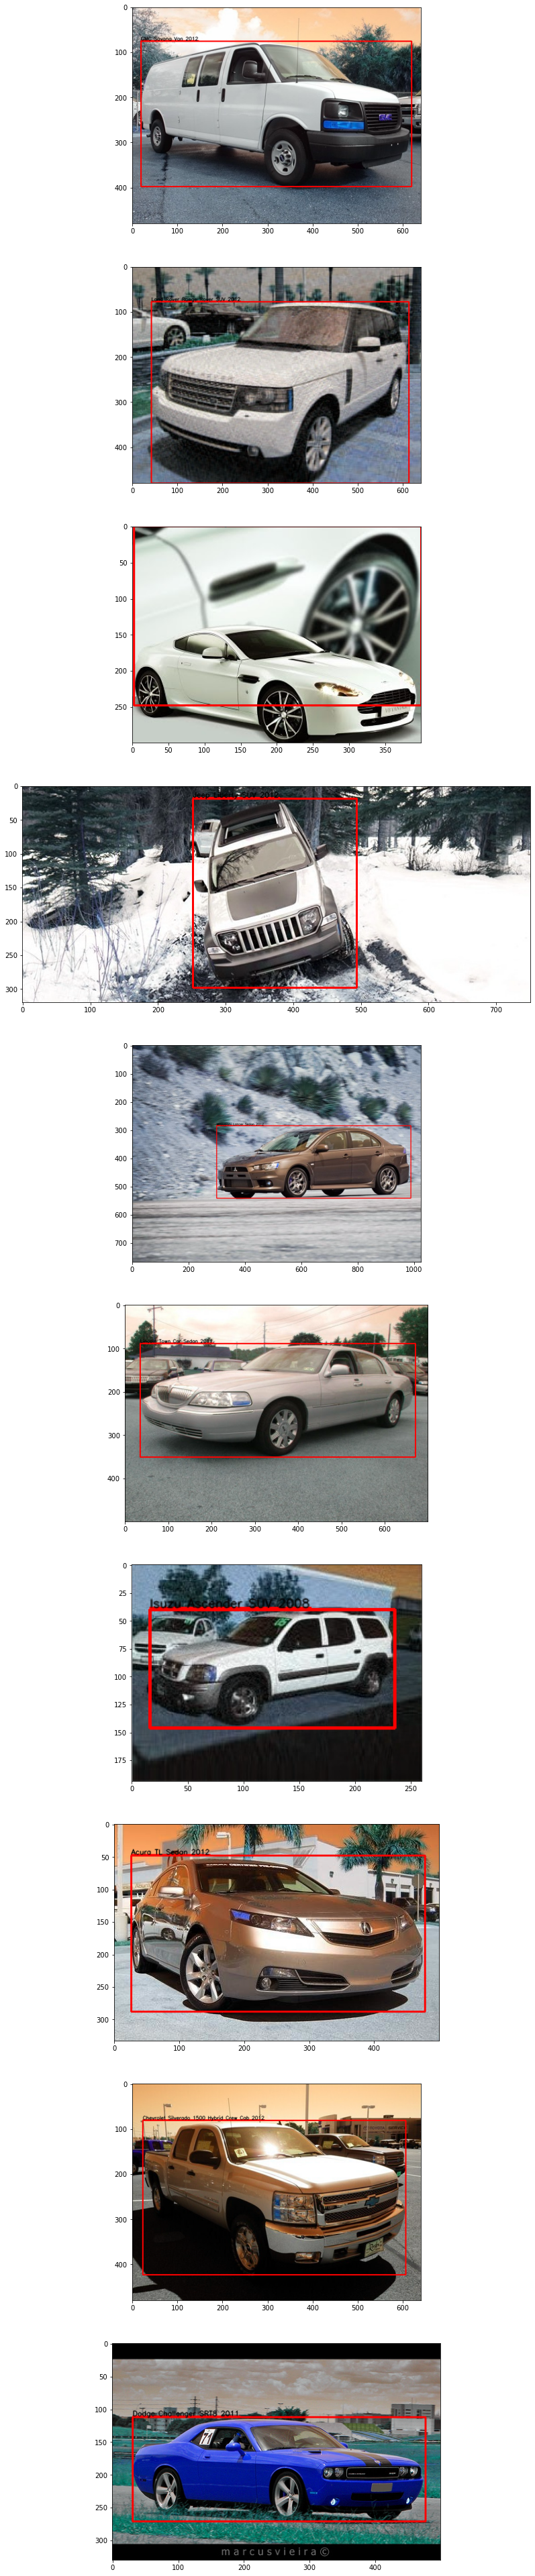

In [84]:
visualize(image_list,bbox_list,class_list)

C:\Users\uprak\capstone\Car Images\Train Images\Chevrolet Express Van 2007\00100.jpg
(360, 480, 3)


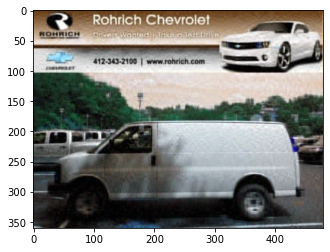

In [118]:
orig_img_path = list(df_train['Image_Path'])
image = orig_img_path[99]
print(image)
img = cv2.imread(image,cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)
plt.show()

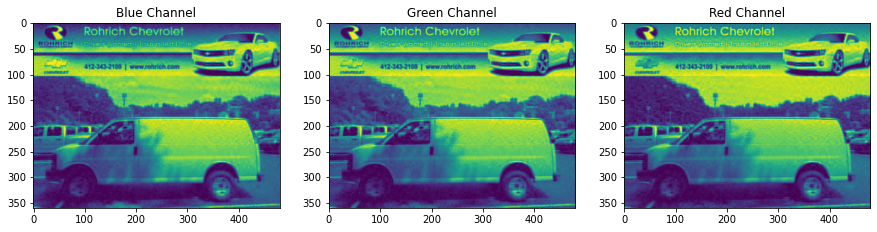

In [93]:
red,green,blue = cv2.split(img)
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Blue Channel")
plt.imshow(blue)
fig.add_subplot(132)
plt.title("Green Channel")
plt.imshow(green)
fig.add_subplot(133)
plt.title("Red Channel")
plt.imshow(red)
plt.show()

In [94]:
df_blue = blue/255
df_green = green/255
df_red = red/255

In [95]:
from sklearn.decomposition import PCA
from scipy.stats import stats
pca_b = PCA(n_components=40)
pca_b.fit(df_blue)
trans_pca_b = pca_b.transform(df_blue)
pca_g = PCA(n_components=40)
pca_g.fit(df_green)
trans_pca_g = pca_g.transform(df_green)
pca_r = PCA(n_components=40)
pca_r.fit(df_red)
trans_pca_r = pca_r.transform(df_red)

In [96]:
print(trans_pca_b.shape)
print(trans_pca_r.shape)
print(trans_pca_g.shape)

(360, 40)
(360, 40)
(360, 40)


In [97]:
print(f"Blue Channel : {sum(pca_b.explained_variance_ratio_)}")
print(f"Green Channel: {sum(pca_g.explained_variance_ratio_)}")
print(f"Red Channel  : {sum(pca_r.explained_variance_ratio_)}")

Blue Channel : 0.9944291459507676
Green Channel: 0.9943521304638793
Red Channel  : 0.9947486336457025


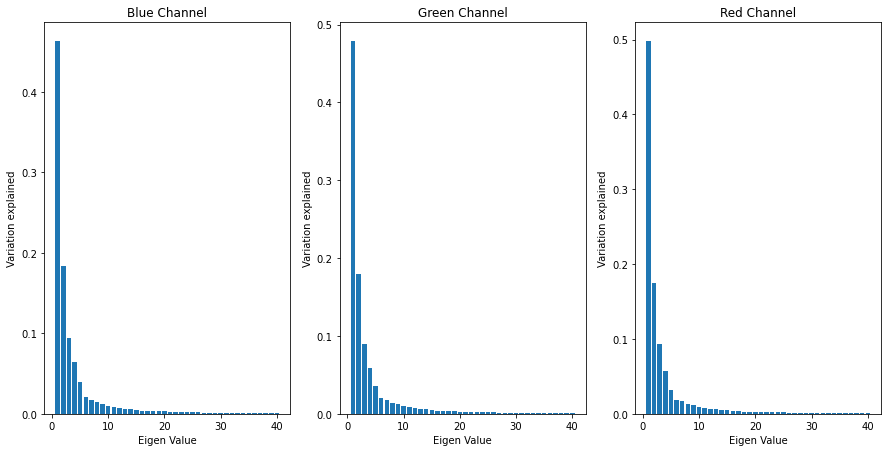

In [99]:
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Blue Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,41)),pca_b.explained_variance_ratio_)
fig.add_subplot(132)
plt.title("Green Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,41)),pca_g.explained_variance_ratio_)
fig.add_subplot(133)
plt.title("Red Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,41)),pca_r.explained_variance_ratio_)
plt.show()

In [100]:
b_arr = pca_b.inverse_transform(trans_pca_b)
g_arr = pca_g.inverse_transform(trans_pca_g)
r_arr = pca_r.inverse_transform(trans_pca_r)
print(b_arr.shape, g_arr.shape, r_arr.shape)

(360, 480) (360, 480) (360, 480)


In [101]:
img_reduced= (cv2.merge((r_arr, g_arr, b_arr)))
print(img_reduced.shape)

(360, 480, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


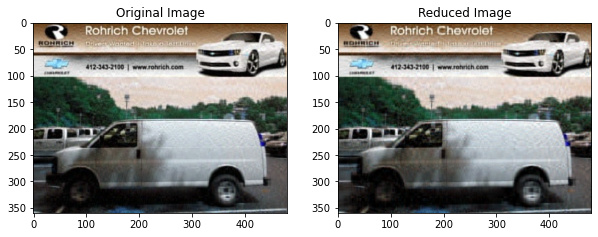

In [102]:
fig = plt.figure(figsize = (10, 7.2)) 
fig.add_subplot(121)
plt.title("Original Image")
plt.imshow(img)
fig.add_subplot(122)
plt.title("Reduced Image")
plt.imshow(img_reduced)
plt.show()